In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
def seed_everything(seed=2020):
    random.seed(seed)
    np.random.seed(seed)
seed_everything(42)

warnings.filterwarnings("ignore")
%matplotlib inline

# Pulsar star

In [2]:
data = pd.read_csv("../input/hr2u-vae/pulsar_stars.csv")
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [3]:
data.shape

(17898, 9)

In [4]:
data.columns = data.columns.str.strip()
data.columns = ['IP Mean', 'IP Sd', 'IP Kurtosis', 'IP Skewness', 
              'DM-SNR Mean', 'DM-SNR Sd', 'DM-SNR Kurtosis', 'DM-SNR Skewness', 'target_class']

In [5]:
# data['target_class'].value_counts()
# view the percentage distribution of target_class column
data['target_class'].value_counts()/np.float(len(data))

0    0.908426
1    0.091574
Name: target_class, dtype: float64

In [6]:
df_ab = data[data['target_class']==1]
df_nnorm = data[data['target_class']!=1]
df_ab.head()

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
19,99.367188,41.572202,1.547197,4.154106,27.555184,61.719016,2.208808,3.662680,1
42,120.554688,45.549905,0.282924,0.419909,1.358696,13.079034,13.312141,212.597029,1
61,27.765625,28.666042,5.770087,37.419009,73.112876,62.070220,1.268206,1.082920,1
92,23.625000,29.948654,5.688038,35.987172,146.568562,82.394624,-0.274902,-1.121848,1
93,94.585938,35.779823,1.187309,3.687469,6.071070,29.760400,5.318767,28.698048,1


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler    = MinMaxScaler()
df_values = df_ab.copy()
column_list = list(df_values.columns) 
df_values = df_values.drop(['target_class'], axis=1)
df_norm   = scaler.fit_transform(df_values)

In [8]:
# X = df_norm.drop(['target_class'],axis=1)
# y= df_norm['target_class']

# V-Autoencoder

In [9]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

import argparse
import os

Using TensorFlow backend.


In [10]:
# network parameters
original_dim= df_values.shape[1]
input_shape = (original_dim, )
intermediate_dim = int(original_dim/2)
batch_size = 128
latent_dim = 8
epochs     = 200
epsilon_std = 1.0

In [11]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [12]:
# VAE Architecture
# * original_dim - Original Input Dimension
# * intermediate_dim - Hidden Layer Dimension
# * latent_dim - Latent Dimension
from keras.layers.normalization import BatchNormalization

def vae_arc(original_dim, intermediate_dim, latent_dim):
    # Encode
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    # h = BatchNormalization()(h)
    # Decode
    decoder = Sequential([
        Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
        Dense(original_dim, activation='sigmoid')
    ])
    z_mu = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

    eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                       shape=(K.shape(x)[0], latent_dim)))
    z_eps = Multiply()([z_sigma, eps])
    z = Add()([z_mu, z_eps])

    x_pred = decoder(z)
    
    return x, eps, z_mu, x_pred

In [13]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [14]:
x, eps, z_mu, x_pred = vae_arc(original_dim, intermediate_dim, latent_dim)
vae            = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

In [15]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4)            36          input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 8)            40          dense_1[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 8)            40          dense_1[0][0]                    
__________________________________________________________________________________________________
kl_diverge

In [16]:
from sklearn.model_selection import train_test_split

# 
X_train, X_test, y_train, y_test = train_test_split(df_norm, df_norm, 
                                                    test_size=0.4, random_state=42)

In [17]:
filepath   ="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [18]:
# train
hist = vae.fit(X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks_list,
        validation_data=(X_test, X_test))

Train on 983 samples, validate on 656 samples
Epoch 1/200
983/983 [==============================] - 4s 4ms/step - loss: 6.0322 - val_loss: 5.8900

Epoch 00001: val_loss improved from inf to 5.88995, saving model to weights.hdf5
Epoch 2/200
983/983 [==============================] - 0s 39us/step - loss: 5.8650 - val_loss: 5.7797

Epoch 00002: val_loss improved from 5.88995 to 5.77975, saving model to weights.hdf5
Epoch 3/200
983/983 [==============================] - 0s 40us/step - loss: 5.7454 - val_loss: 5.6502

Epoch 00003: val_loss improved from 5.77975 to 5.65023, saving model to weights.hdf5
Epoch 4/200
983/983 [==============================] - 0s 47us/step - loss: 5.6428 - val_loss: 5.5717

Epoch 00004: val_loss improved from 5.65023 to 5.57174, saving model to weights.hdf5
Epoch 5/200
983/983 [==============================] - 0s 44us/step - loss: 5.5435 - val_loss: 5.5044

Epoch 00005: val_loss improved from 5.57174 to 5.50444, saving model to weights.hdf5
Epoch 6/200
983/983

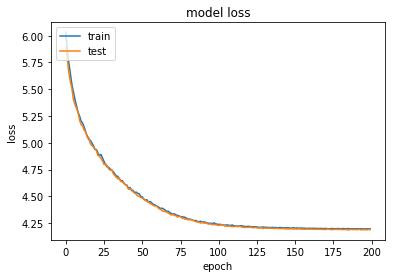

In [19]:
def plt_hist(hist):
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt_hist(hist)

In [20]:
# Predict Embedding values
encoder = Model(x, z_mu)
z_df    = encoder.predict(df_norm, batch_size=batch_size)

In [21]:
df_vae = pd.DataFrame(z_df)
df_vae['target_class'] = 1
df_vae.columns = column_list
df_vae.head(10)

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
0,0.007231,0.005723,0.002994,-0.010600,0.002677,0.001066,-0.011590,-0.000691,1
1,-0.002782,0.028356,-0.027113,-0.034668,0.038733,-0.007040,0.015272,-0.004050,1
2,-0.004064,-0.006800,-0.000778,0.015485,-0.003537,-0.000535,0.009366,0.000526,1
3,-0.004064,-0.006800,-0.000778,0.015485,-0.003537,-0.000535,0.009366,0.000526,1
4,0.012732,0.011822,0.004832,-0.023306,0.005704,0.001847,-0.021796,-0.001284,1
5,0.000644,-0.001580,0.000794,0.004613,-0.000947,0.000132,0.000632,0.000019,1
6,0.005219,0.003493,0.002323,-0.005955,0.001571,0.000781,-0.007858,-0.000474,1
7,-0.004064,-0.006800,-0.000778,0.015485,-0.003537,-0.000535,0.009366,0.000526,1
8,-0.004064,-0.006800,-0.000778,0.015485,-0.003537,-0.000535,0.009366,0.000526,1
9,-0.004064,-0.006800,-0.000778,0.015485,-0.003537,-0.000535,0.009366,0.000526,1


In [22]:
df_nvalues = data.drop(['target_class'], axis=1)
scaled_nnorm   = scaler.fit_transform(df_nvalues)
df_scaler_nnorm = pd.DataFrame(scaled_nnorm, index=df_nvalues.index, columns=df_nvalues.columns)
df_scaler_nnorm['target_class'] = data.target_class
df_train = pd.concat([df_vae, df_scaler_nnorm], ignore_index=True)
df_train.shape

(19537, 9)

In [23]:
X = df_train.drop(['target_class'], axis=1)
y = df_train['target_class']

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Model

In [25]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, confusion_matrix,precision_recall_curve,auc,f1_score,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [26]:

def model(algorithm,dtrain_x,dtrain_y,dtest_x,dtest_y):
    
    print ("MODEL - OUTPUT")
    print ("*****************************************************************************************")
    algorithm.fit(dtrain_x,dtrain_y)
    predictions = algorithm.predict(dtest_x)
    
    print (algorithm)
    print ("\naccuracy_score :",accuracy_score(dtest_y,predictions))
    print ("\nrecall score:\n",(recall_score(dtest_y,predictions)))
    print ("\nf1 score:\n",(f1_score(dtest_y,predictions)))
#     print ("\nclassification report :\n",(classification_report(dtest_y,predictions)))
    print ("\nmatthews_corrcoef:\n", (matthews_corrcoef(dtest_y, predictions)))
    #cross validation
    
    # Graph
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True,fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)
    
    predicting_probabilites = algorithm.predict_proba(dtest_x)[:,1]
    fpr,tpr,thresholds = roc_curve(dtest_y,predicting_probabilites)
    plt.subplot(222)
    plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)


MODEL - OUTPUT
*****************************************************************************************
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

accuracy_score : 0.9704878880928011

recall score:
 0.9186652763295099

f1 score:
 0.9105943152454781

matthews_corrcoef:
 0.8929724838880628


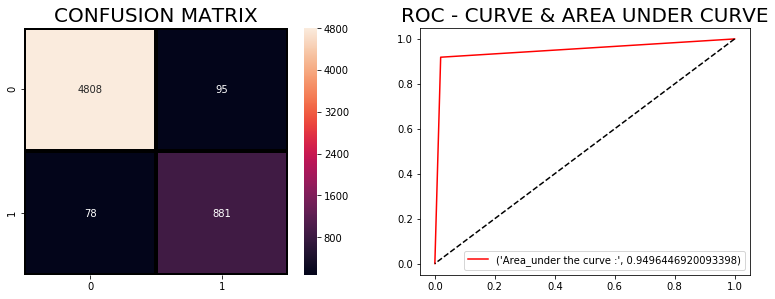

In [27]:
clf = DecisionTreeClassifier()
model(clf ,X_train,y_train,X_test,y_test)

MODEL - OUTPUT
*****************************************************************************************
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

accuracy_score : 0.9769703172978506

recall score:
 0.8884254431699687

f1 score:
 0.9265905383360523

matthews_corrcoef:
 0.9141498426831812


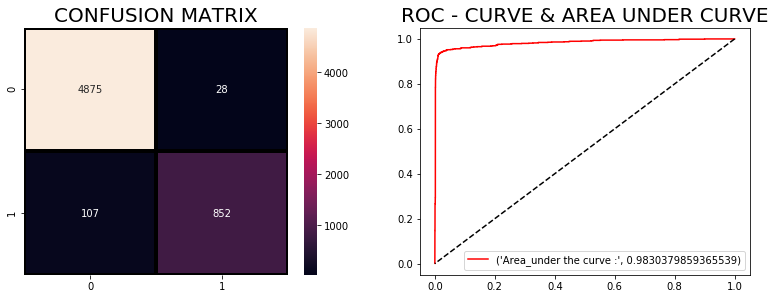

In [28]:
svc=SVC(probability=True) 

model(svc ,X_train,y_train,X_test,y_test)